In [24]:
import numpy as np
import pandas as pd
from statistics import mean
from statistics import pstdev
from scipy import stats
import csv
import re
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from openpyxl import load_workbook

In [23]:
mutability_scores = pd.read_excel(io='Spencer_et_al_2017_Cas9_mutagenesis.xlsx',
                   sheet_name='Mutability Scores')

mutability_scores_list = mutability_scores['Mutability Score'].tolist()
mean_mutability_score = mean(mutability_scores_list)
stdev_mutability_score = pstdev(mutability_scores_list)

for index, row in mutability_scores.iterrows():
    normalized_mutability_score = (row[1] - mean_mutability_score)/stdev_mutability_score
    mutability_scores = mutability_scores.replace(row[1], normalized_mutability_score)

In [4]:
df1 = pd.read_excel(io='Spencer_et_al_2017_Cas9_mutagenesis.xlsx',
                   sheet_name='All Count Data')

df1.drop_duplicates(subset=['AA Position'], inplace=True)

s1 = pd.Series(df1['AA Position'], name='AA Position')
s2 = pd.Series(df1['Domain'], name='Domain')

aa_domains = pd.concat([s1,s2], axis=1)

In [5]:
aa_domains_mutability = pd.merge(aa_domains, mutability_scores, on=['AA Position'])

aa_domains_mutability = aa_domains_mutability.dropna()

aa_domains_mutability.to_excel('AminoAcids_Domains_Mutability.xlsx')

In [33]:
aa_domains_mutability = pd.read_excel('AminoAcids_Domains_Mutability.xlsx')
aa_domains_mutability = aa_domains_mutability.dropna()

In [34]:
with open('FinalSum_Cas9RNP_NoNodeEdgeBetweenness') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t')
    aa_network_scores = pd.DataFrame(csv_reader, columns=['AA Position','Network Score'])

aa_network_scores = aa_network_scores[aa_network_scores['Network Score'] != 'NA']

aa_network_scores['Network Score'] = aa_network_scores['Network Score'].astype(float)
aa_network_scores = aa_network_scores.sort_values(by=['Network Score'])

for aa in aa_network_scores['AA Position']:
    aa_new = int(re.sub('\D', '', aa))
    aa_network_scores = aa_network_scores.replace(to_replace=aa, value=aa_new)


aa_network_scores = aa_network_scores.sort_values(by=['AA Position'])

aa_network_scores.to_excel('AminoAcids_NetworkScores.xlsx')

In [35]:
aa_domains_network_mutability = pd.merge(aa_network_scores, aa_domains_mutability, on=['AA Position'])
columns_swap = ['AA Position','Domain','Network Score','Mutability Score']
aa_domains_network_mutability=aa_domains_network_mutability.reindex(columns=columns_swap)

aa_domains_network_mutability.to_excel('Mutability_NetworkScores.xlsx')

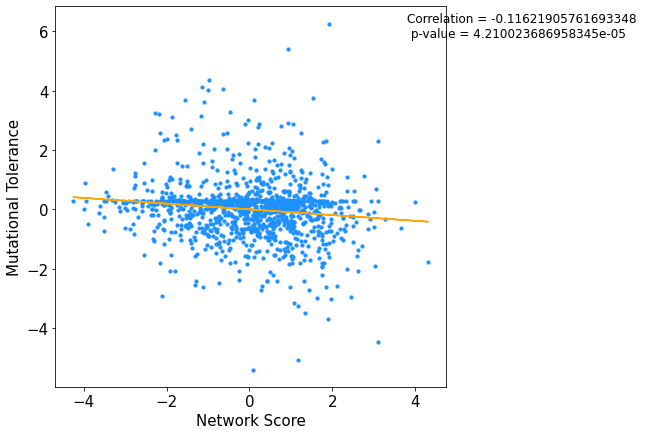

In [36]:
fig = plt.figure(figsize = (7,7))
x_vals = aa_domains_network_mutability.loc[:,'Network Score']
y_vals = aa_domains_network_mutability.loc[:,'Mutability Score']
plt.scatter(x_vals, y_vals, s=10, color='dodgerblue')
m, b = np.polyfit(x_vals, y_vals, 1)
plt.plot(x_vals, m*x_vals + b, color='orange')
plt.xlabel('Network Score', fontsize = 15)
plt.ylabel('Mutational Tolerance', fontsize = 15)
#plt.title('Structural Network Analysis of Cas9 Mutational Tolerance', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

model_x = np.array(x_vals).reshape((-1,1))
model_y = np.array(y_vals)
correlation, pvalue = stats.spearmanr(model_x, model_y)
fig_text = 'Correlation = {} \n p-value = {}'.format(correlation,pvalue)
plt.text(3.8,5.8, fig_text, fontsize = 12)
plt.show()

In [37]:
def domain_scorer(df, domain_name):
    rows = df[df['Domain'].str.contains(domain_name)]
    x_vals = rows.loc[:,'Network Score']
    y_vals = rows.loc[:,'Mutability Score']
    
    return x_vals, y_vals

In [38]:
RuvC_x_vals, RuvC_y_vals = domain_scorer(aa_domains_network_mutability, 'RuvC')
BH_x_vals, BH_y_vals = domain_scorer(aa_domains_network_mutability, 'BH')
Rec1_x_vals, Rec1_y_vals = domain_scorer(aa_domains_network_mutability, 'Rec1')
Rec2_x_vals, Rec2_y_vals = domain_scorer(aa_domains_network_mutability, 'Rec2')
HNH_x_vals, HNH_y_vals = domain_scorer(aa_domains_network_mutability, 'HNH')
PI_x_vals, PI_y_vals = domain_scorer(aa_domains_network_mutability, 'PI')
Mut_x_vals, Mut_y_vals = domain_scorer(aa_domains_network_mutability, 'Mut')
print(Mut_x_vals)

56      0.971807
257    -0.058288
307     0.314187
392     1.466084
463     0.727446
478     1.752496
480    -0.475093
498     2.349051
509     1.893028
526    -1.643012
644    -0.144161
677     1.849914
678    -0.453915
681     1.435106
1100   -1.217146
1186   -2.364115
1191   -2.379234
1202   -0.208236
Name: Network Score, dtype: float64


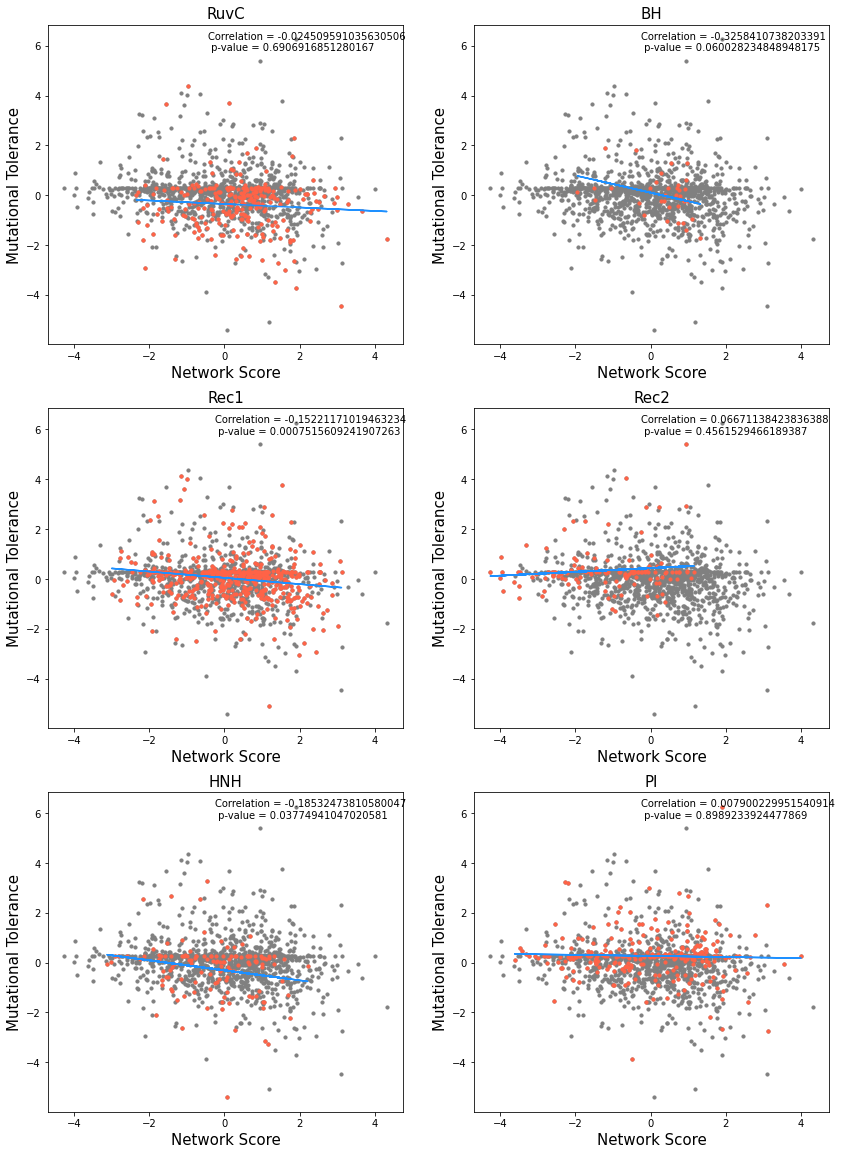

In [11]:
fig, axs = plt.subplots(3,2, figsize=(14,20))
axs[0,0].scatter(x_vals, y_vals, s=10, color='grey')
axs[0,0].scatter(RuvC_x_vals, RuvC_y_vals, s=10, color='tomato')
m, b = np.polyfit(RuvC_x_vals, RuvC_y_vals, 1)
axs[0,0].plot(RuvC_x_vals, m*RuvC_x_vals + b, color='dodgerblue')
axs[0,0].set_xlabel('Network Score', fontsize=15)
axs[0,0].set_ylabel('Mutational Tolerance', fontsize=15)
axs[0,0].set_title('RuvC', fontsize=15)

model_x = np.array(RuvC_x_vals).reshape((-1,1))
model_y = np.array(RuvC_y_vals)
correlation, pvalue = stats.spearmanr(model_x, model_y)
spearman_patch = mpatches.Patch(facecolor='None',
                                label='Correlation = {} \n p-value = {}'.
                                format(correlation,pvalue))
axs[0,0].legend(loc=[0.36,0.9], handles=[spearman_patch], frameon=False, fontsize=10)

axs[0,1].scatter(x_vals, y_vals, s=10, color='grey')
axs[0,1].scatter(BH_x_vals, BH_y_vals, s=10, color='tomato')
m, b = np.polyfit(BH_x_vals, BH_y_vals, 1)
axs[0,1].plot(BH_x_vals, m*BH_x_vals + b, color='dodgerblue')
axs[0,1].set_xlabel('Network Score', fontsize=15)
axs[0,1].set_ylabel('Mutational Tolerance', fontsize=15)
axs[0,1].set_title('BH', fontsize=15)

model_x = np.array(BH_x_vals).reshape((-1,1))
model_y = np.array(BH_y_vals)
correlation, pvalue = stats.spearmanr(model_x, model_y)
spearman_patch = mpatches.Patch(facecolor='None',
                                label='Correlation = {} \n p-value = {}'.format(correlation,pvalue))
axs[0,1].legend(loc=[0.38,0.9], handles=[spearman_patch], frameon=False, fontsize=10)

axs[1,0].scatter(x_vals, y_vals, s=10, color='grey')
axs[1,0].scatter(Rec1_x_vals, Rec1_y_vals, s=10, color='tomato')
m, b = np.polyfit(Rec1_x_vals, Rec1_y_vals, 1)
axs[1,0].plot(Rec1_x_vals, m*Rec1_x_vals + b, color='dodgerblue')
axs[1,0].set_xlabel('Network Score', fontsize=15)
axs[1,0].set_ylabel('Mutational Tolerance', fontsize=15)
axs[1,0].set_title('Rec1', fontsize=15)

model_x = np.array(Rec1_x_vals).reshape((-1,1))
model_y = np.array(Rec1_y_vals)
correlation, pvalue = stats.spearmanr(model_x, model_y)
spearman_patch = mpatches.Patch(facecolor='None',
                                label='Correlation = {} \n p-value = {}'.format(correlation,pvalue))
axs[1,0].legend(loc=[0.38,0.9], handles=[spearman_patch], frameon=False, fontsize=10)

axs[1,1].scatter(x_vals, y_vals, s=10, color='grey')
axs[1,1].scatter(Rec2_x_vals, Rec2_y_vals, s=10, color='tomato')
m, b = np.polyfit(Rec2_x_vals, Rec2_y_vals, 1)
axs[1,1].plot(Rec2_x_vals, m*Rec2_x_vals + b, color='dodgerblue')
axs[1,1].set_xlabel('Network Score', fontsize=15)
axs[1,1].set_ylabel('Mutational Tolerance', fontsize=15)
axs[1,1].set_title('Rec2', fontsize=15)

model_x = np.array(Rec2_x_vals).reshape((-1,1))
model_y = np.array(Rec2_y_vals)
correlation, pvalue = stats.spearmanr(model_x, model_y)
spearman_patch = mpatches.Patch(facecolor='None',
                                label='Correlation = {} \n p-value = {}'.format(correlation,pvalue))
axs[1,1].legend(loc=[0.38,0.9], handles=[spearman_patch], frameon=False, fontsize=10)

axs[2,0].scatter(x_vals, y_vals, s=10, color='grey')
axs[2,0].scatter(HNH_x_vals, HNH_y_vals, s=10, color='tomato')
m, b = np.polyfit(HNH_x_vals, HNH_y_vals, 1)
axs[2,0].plot(HNH_x_vals, m*HNH_x_vals + b, color='dodgerblue')
axs[2,0].set_xlabel('Network Score', fontsize=15)
axs[2,0].set_ylabel('Mutational Tolerance', fontsize=15)
axs[2,0].set_title('HNH', fontsize=15)

model_x = np.array(HNH_x_vals).reshape((-1,1))
model_y = np.array(HNH_y_vals)
correlation, pvalue = stats.spearmanr(model_x, model_y)
spearman_patch = mpatches.Patch(facecolor='None',
                                label='Correlation = {} \n p-value = {}'.format(correlation,pvalue))
axs[2,0].legend(loc=[0.38,0.9],handles=[spearman_patch], frameon=False, fontsize=10)


axs[2,1].scatter(x_vals, y_vals, s=10, color='grey')
axs[2,1].scatter(PI_x_vals, PI_y_vals, s=10, color='tomato')
m, b = np.polyfit(PI_x_vals, PI_y_vals, 1)
axs[2,1].plot(PI_x_vals, m*PI_x_vals + b, color='dodgerblue')
axs[2,1].set_xlabel('Network Score', fontsize=15)
axs[2,1].set_ylabel('Mutational Tolerance', fontsize=15)
axs[2,1].set_title('PI', fontsize=15)


model_x = np.array(PI_x_vals).reshape((-1,1))
model_y = np.array(PI_y_vals)
correlation, pvalue = stats.spearmanr(model_x, model_y)
spearman_patch = mpatches.Patch(facecolor='None',
                                label='Correlation = {} \n p-value = {}'.format(correlation,pvalue))
axs[2,1].legend(loc=[0.38,0.9], handles=[spearman_patch], frameon=False, fontsize=10)

plt.show()
fig.savefig('Structural Network Analysis by Domain.jpg', bbox_inches='tight')

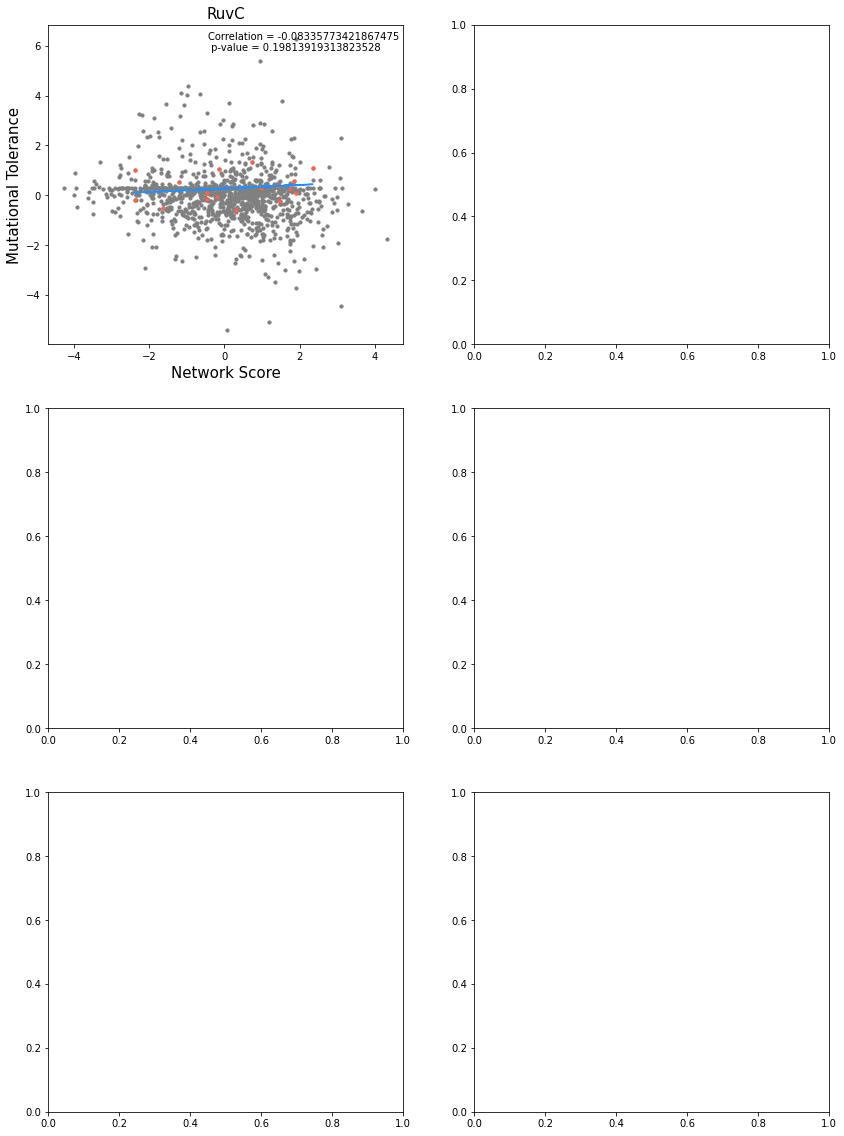

In [39]:
fig, axs = plt.subplots(3,2, figsize=(14,20))
axs[0,0].scatter(x_vals, y_vals, s=10, color='grey')
axs[0,0].scatter(Mut_x_vals, Mut_y_vals, s=10, color='tomato')
m, b = np.polyfit(Mut_x_vals, Mut_y_vals, 1)
axs[0,0].plot(Mut_x_vals, m*Mut_x_vals + b, color='dodgerblue')
axs[0,0].set_xlabel('Network Score', fontsize=15)
axs[0,0].set_ylabel('Mutational Tolerance', fontsize=15)
axs[0,0].set_title('RuvC', fontsize=15)

model_x = np.array(RuvC_x_vals).reshape((-1,1))
model_y = np.array(RuvC_y_vals)
correlation, pvalue = stats.spearmanr(model_x, model_y)
spearman_patch = mpatches.Patch(facecolor='None',
                                label='Correlation = {} \n p-value = {}'.
                                format(correlation,pvalue))
axs[0,0].legend(loc=[0.36,0.9], handles=[spearman_patch], frameon=False, fontsize=10)